<a href="https://colab.research.google.com/github/rinas21/rice-type-tabular-classification/blob/main/notebooks/my_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
!pip install opendatasets --quiet # Installs the opendataset package.
import opendatasets as od # Imports the opendataset package and assigns it to the alias 'od'.
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification") # Downloads the dataset using the opendataset library.


Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [133]:
data_df=pd.read_csv('rice-type-classification/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [134]:
data_df.dropna(inplace=True)
data_df.drop(['id'],axis=1,inplace=True)
print(data_df.shape)

(18185, 11)


In [135]:
original_df=data_df.copy()
for column in data_df.columns:
    data_df[column]=data_df[column]/data_df[column].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [136]:
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:,-1])

In [137]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3)

In [138]:
X_test,X_val,Y_test,Y_val=train_test_split(X_test,Y_test,test_size=0.5)

In [139]:
print(X_train.shape,X_test.shape,X_val.shape)

(12729, 10) (2728, 10) (2728, 10)


In [140]:
class dataset(Dataset):
  def __init__(self,x,y):
    self.X=torch.tensor(X,dtype=torch.float32).to(device)
    self.Y=torch.tensor(Y,dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index],self.Y[index]

In [141]:
training_data=dataset(X_train,Y_train)
testing_data=dataset(X_test,Y_test)
validation_data=dataset(X_val,Y_val)

In [142]:
train_dataloader=DataLoader(training_data,batch_size=32,shuffle=True)
test_dataloader=DataLoader(testing_data,batch_size=32,shuffle=True)
val_dataloader=DataLoader(validation_data,batch_size=32,shuffle=True)

In [143]:
class MyModel(nn.Module):
        def __init__(self):
          super(MyModel,self).__init__()
          self.input_layer=nn.Linear(X.shape[1],64) # Increased neurons
          self.hidden_layer = nn.Linear(64, 32)  # Added hidden layer
          self.Linear=nn.Linear(32,1)
          self.relu = nn.ReLU()             # Using ReLU activation
          self.sigmoid=nn.Sigmoid()

        def forward(self,x):
          x=self.relu(self.input_layer(x))  # Apply ReLU
          x = self.relu(self.hidden_layer(x)) # Apply ReLU to hidden layer
          x=self.Linear(x)
          x=self.sigmoid(x)
          return x

model=MyModel().to(device)

In [144]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             704
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
           Sigmoid-6                    [-1, 1]               0
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [145]:
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=1e-3)

In [146]:
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

epoches=10
for epoch in range(epoches):
  total_loss_train=0
  total_loss_validation=0
  total_acc_train=0
  total_acc_validation=0

  for data in train_dataloader:
    inputs ,labels=data

    prediction =model(inputs).squeeze(1)
    batch_loss=criterion(prediction,labels)

    total_loss_train+=batch_loss.item()
    acc=((prediction).round()==labels).sum().item()

    total_acc_train+=acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in val_dataloader:
      inputs ,labels=data

      prediction =model(inputs).squeeze(1)
      batch_loss=criterion(prediction,labels)

      total_loss_validation+=batch_loss.item()
      acc=((prediction).round()==labels).sum().item()
      total_acc_validation+=acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_validation/1000,4))


  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() *100,4))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__() *100,4))

  print(f'''Epoch {epoch+1} Train Loss:{round(total_loss_train/1000,4)} Train Accuracy:{round(total_acc_train/training_data.__len__() *100,4)}
        validation Loss:{round(total_loss_validation/1000,4)} validation Accuracy:{round(total_acc_validation/validation_data.__len__() *100,4)}''')

  print("="*25)

Epoch 1 Train Loss:0.3994 Train Accuracy:45.0921
        validation Loss:0.3994 validation Accuracy:45.0921
Epoch 2 Train Loss:0.3994 Train Accuracy:45.0921
        validation Loss:0.3994 validation Accuracy:45.0921
Epoch 3 Train Loss:0.3994 Train Accuracy:45.0921
        validation Loss:0.3994 validation Accuracy:45.0921
Epoch 4 Train Loss:0.3994 Train Accuracy:45.0921
        validation Loss:0.3994 validation Accuracy:45.0921
Epoch 5 Train Loss:0.3994 Train Accuracy:45.0921
        validation Loss:0.3994 validation Accuracy:45.0921
Epoch 6 Train Loss:0.3994 Train Accuracy:45.0921
        validation Loss:0.3994 validation Accuracy:45.0921
Epoch 7 Train Loss:0.3994 Train Accuracy:45.0921
        validation Loss:0.3994 validation Accuracy:45.0921
Epoch 8 Train Loss:0.3994 Train Accuracy:45.0921
        validation Loss:0.3994 validation Accuracy:45.0921
Epoch 9 Train Loss:0.3994 Train Accuracy:45.0921
        validation Loss:0.3994 validation Accuracy:45.0921
Epoch 10 Train Loss:0.3994 T

In [147]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0
  for data in test_dataloader:
    inputs,labels=data

    predction=model(inputs).squeeze(1)
    batch_loss_test=criterian(predction,labels).item()

    total_loss_test+=batch_loss_test
    acc=((predction).round()==labels).sum().item()
    total_acc_test+=acc

print("Accuracy: ",round(total_acc_test/testing_data.__len__() *100,4))

Accuracy:  45.0921


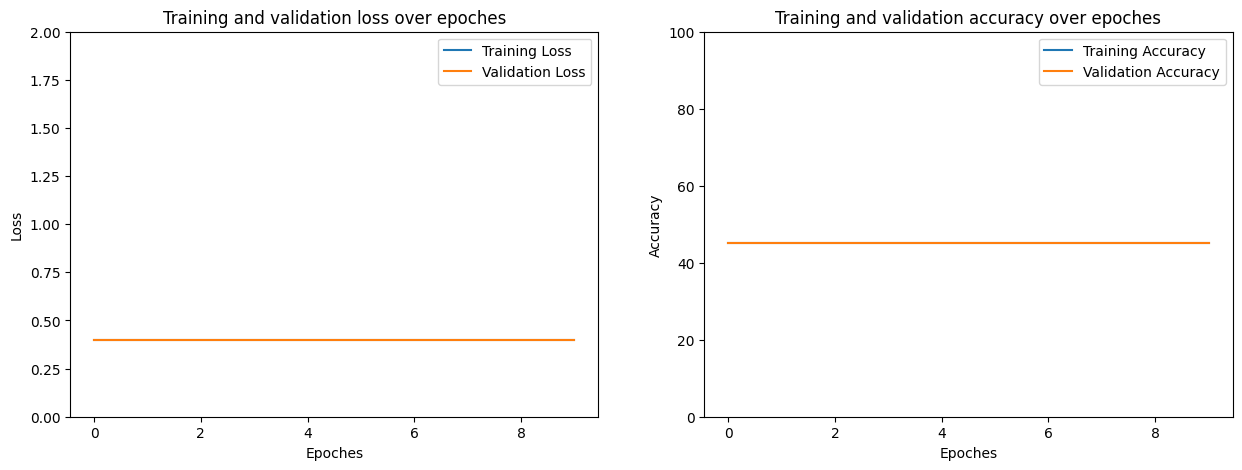

In [148]:
fig,axs=plt.subplots(1,2,figsize=(15,5))

axs[0].plot(total_loss_train_plot,label='Training Loss')
axs[0].plot(total_loss_validation_plot,label='Validation Loss')
axs[0].set_title('Training and validation loss over epoches')
axs[0].set_xlabel('Epoches')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot,label='Training Accuracy')
axs[1].plot(total_acc_validation_plot,label='Validation Accuracy')
axs[1].set_title('Training and validation accuracy over epoches')
axs[1].set_xlabel('Epoches')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()


In [153]:
area=2353/original_df['Area'].abs().max()
MajorAxisLength=81/original_df['MajorAxisLength'].abs().max()
MinorAxisLength=42/original_df['MinorAxisLength'].abs().max()
Eccentricity=32/original_df['Eccentricity'].abs().max()
ConvexArea=12/original_df['ConvexArea'].abs().max()
EquivDiameter=33/original_df['EquivDiameter'].abs().max()
Extent=98/original_df['Extent'].abs().max()
Perimeter=927/original_df['Perimeter'].abs().max()
Roundness=677/original_df['Roundness'].abs().max()
AspectRation=24/original_df['AspectRation'].abs().max()
my_prediction=model(torch.tensor([[area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation]],dtype=torch.float32).to(device))

In [159]:
round(my_prediction.item())

0